# Introduction

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/moviereview/rottentomatoes-400k.csv')
df = df.drop(df.columns[0], axis=1)
df = df[df['Date'] != '1800-01-01']
df = df[df['Date'] != '1927-08-12']
df.head()

,Movie,Reviewer,Publish,Review,Date,Score
0,HOTEL TRANSYLVANIA: TRANSFORMANIA,James Luxford,City AM,I guess its always been hard for me to see the...,03/03/2022,40.0
1,HOTEL TRANSYLVANIA: TRANSFORMANIA,Mat Brunet,AniMat's Review (YouTube),Hotel Transylvania: Transformania is a present...,15/02/2022,30.0
2,HOTEL TRANSYLVANIA: TRANSFORMANIA,Robert Levin,Newsday,The conceit still works well enough to mostly ...,29/01/2022,75.0
3,HOTEL TRANSYLVANIA: TRANSFORMANIA,Jackie K. Cooper,jackiekcooper.com,"No Adam Sandler this time out, but the animate...",28/01/2022,60.0
4,HOTEL TRANSYLVANIA: TRANSFORMANIA,Asher Luberto,The Playlist,It's not likely we'll see another one of these...,28/01/2022,74.0


## Clean the Data

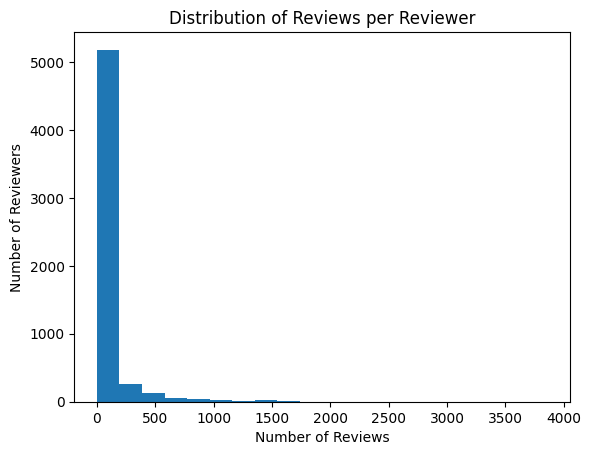

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of reviews per reviewer
review_counts = df.groupby('Reviewer')['Movie'].count()

# Plot a histogram of the review counts
plt.hist(review_counts, bins=20)
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Reviewers")
plt.title("Distribution of Reviews per Reviewer")
plt.show()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

threshold_date = pd.to_datetime('2010-01-01')
df = df[df['Date'] > threshold_date]

In [ ]:
# Calculate the number of reviews per reviewer
review_counts = df.groupby('Reviewer')['Movie'].count()

# Select reviewers with between 10 and 100 reviews
reviewer_subset = review_counts[(review_counts >= 10) & (review_counts <= 100)]

# If a reviewer has more than 100 reviews, randomly select 100
reviewer_subset = pd.concat([reviewer_subset,
                             review_counts[review_counts > 100].sample(n= 100, random_state=123)],
                            axis=0)

selected_data = df[df['Reviewer'].isin(reviewer_subset.index)]


selected_data = selected_data.groupby('Reviewer').filter(lambda x: len(x) >= 10)

selected_data = selected_data.sample(frac=1, random_state=123)

# Print some summary statistics
print("Number of selected reviews: ", len(selected_data))
print("Number of selected reviewers: ", len(selected_data['Reviewer'].unique()))


Number of selected reviews:  88424
Number of selected reviewers:  1518


In [ ]:
df = selected_data

# EDA and Plots

### Numbers of Movies, Reviews, Reviewers

In [ ]:
print("Number of Movies:", df['Movie'].nunique())
print("Number of Reviewers:", df['Reviewer'].nunique())
print("Number of Reviews:", df['Review'].count())


Number of Movies: 8019
Number of Reviewers: 1518
Number of Reviews: 88424


### Check missing values

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

Movie       0
Reviewer    0
Publish     0
Review      0
Date        0
Score       0
dtype: int64


In [ ]:

df['Year'] = df['Date'].dt.year

### Text Length Distribution

In [ ]:
df['Length'] = df['Review'].apply(lambda x: len(x.split()))

In [ ]:
import plotly.express as px

# Create a histogram of the distribution of the lengths using Plotly
fig = px.histogram(df, x='Length', nbins=100, title='Distribution of Sentence Lengths')

# Show the plot
fig.show()

### Top 10 Movie Reviews

In [ ]:
top_movies = df.groupby('Movie').size().reset_index(name='Count').sort_values('Count', ascending=False).head(10)
fig = px.bar(top_movies, x='Movie', y='Count', title='Top 10 Movies by Reviews Count')
fig.show()

### average reviews per person

In [ ]:
# Calculate the total number of reviews per reviewer
review_counts = df.groupby('Reviewer')['Movie'].count()

# Calculate the average number of reviews per reviewer
avg_reviews_per_reviewer = review_counts.mean()

print("Average reviews per reviewer: ", avg_reviews_per_reviewer)

Average reviews per reviewer:  58.250329380764164


### number of reviews over year

In [ ]:
# Extract the year from the date column
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Count the distinct reviewers for each year
distinct_reviewers = df.groupby('Year')['Reviewer'].nunique()

# Create a Plotly bar chart
fig = px.bar(distinct_reviewers, x=distinct_reviewers.index, y=distinct_reviewers.values,
             labels={'x':'Year', 'y':'Distinct Reviewers'})

# Show the plot
fig.show()

### Distribution of year

In [ ]:

year_counts = df.groupby('Year').size().reset_index(name='Count')
fig = px.pie(year_counts, values='Count', names='Year', title='Number of Reviews per Year')
fig.show()

### Score over year

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Assuming you have a 'Date', 'Score', and 'Reviewer' column in your DataFrame
df['Year'] = pd.to_datetime(df['Date']).dt.year

# Calculate mean_score_by_year
mean_score_by_year = df.groupby('Year')['Score'].mean()

# Count distinct_reviewers
distinct_reviewers = df.groupby('Year')['Reviewer'].nunique()

# Create a Plotly figure
fig = go.Figure()




# Add a bar plot for the number of distinct reviewers
fig.add_trace(go.Bar(x=distinct_reviewers.index, y=distinct_reviewers.values,
                     name='Distinct Reviewers'))

# Add a line plot for the average score
fig.add_trace(go.Scatter(x=mean_score_by_year.index, y=mean_score_by_year.values,
                         mode='lines', name='Average Score', yaxis='y2'))

# Update the layout to include a secondary y-axis
fig.update_layout(
    yaxis=dict(title='Distinct Reviewers'),
    yaxis2=dict(title='Average Score', overlaying='y', side='right')
)

# Update the x-axis label
fig.update_xaxes(title_text='Year')

# Show the combined plot
fig.show()


## Convert score into category

In [ ]:
bins = [0, 50 , 100]
labels = [ 0,1]

# Cut the score column into categories using the bins and labels
df['category'] = pd.cut(df['Score'], bins=bins, labels=labels, include_lowest=True)

# Map the categories to the new range using a lambda function
df['new_score'] = df['category'].map(lambda x: x * 1.0)

# Drop the intermediate category column
df = df.drop('category', axis=1)
df.head()

,Movie,Reviewer,Publish,Review,Date,Score,Year,Length,new_score
143373,SEASONS,Matt Fagerholm,RogerEbert.com,There are numerous thrilling sights to behold.,2016-12-02,75.0,2016,7,1.0
259200,THE ATTACK,Leba Hertz,San Francisco Chronicle,Imagine a blissful life taken away: Story of a...,2013-08-08,62.5,2013,41,1.0
316069,SPORK,Tim Cogshell,Boxoffice Magazine,"A quirky, imaginative and outrageously funny l...",2011-06-06,60.0,2011,23,1.0
229133,PALO ALTO,Steve Davis,Austin Chronicle,"As lovely as it sometimes is, what this film n...",2014-05-29,60.0,2014,41,1.0
47620,YESTERDAY,Andrea G. Bermejo,Cinemanía (Spain),The scriptwriter sustains Yesterday's love sto...,2019-07-01,60.0,2019,18,1.0


# Preprocessing

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]

    # Rejoining tokens
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text, tokens

# Assuming 'df' is your DataFrame with a 'Review' column
df['Preprocessed_Review'], df['Tokenized_Review'] = zip(*df['Review'].apply(preprocess_text))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['Preprocessed_Review']



143373                            numer thrill sight behold
259200    imagin bliss life taken away stori arab man wh...
316069    quirki imagin outrag funni littl movi speak us...
229133    love sometim film need littl shape littl less ...
47620     scriptwrit sustain yesterday love stori upon p...
                                ...                        
255523    jackman grown role carri around rough hemp sac...
247190    stubborn charmer whose life magnet tragedi hal...
64581     mani scifi film reli heavili visual effect idi...
105240    futur shelf life seminari seem like festiv tre...
56931     halloween kill excit addit halloween franchis ...
Name: Preprocessed_Review, Length: 88424, dtype: object

# LDA Topic analysis

In [ ]:

pip install pyLDAvis


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.2 MB/s eta 0:00:00


In [ ]:
pip install pyLADvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pyLADvis (from versions: none)
ERROR: No matching distribution found for pyLADvis


In [ ]:
import re
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer


### finding the best LDA model

In [ ]:
def lda_model_tuning(df, start=2, limit=10, step=1):
    coherence_scores = []
    models = []
    for num_topics in range(start, limit, step):
        # Create a dictionary from the preprocessed tokens
        id2word = corpora.Dictionary(df['Tokenized_Review'])

        # Create a corpus from the dictionary
        corpus = [id2word.doc2bow(text) for text in df['Tokenized_Review']]

        # Train the LDA model
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=num_topics,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)

        # Compute coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=df['Tokenized_Review'], dictionary=id2word, coherence='c_v')
        coherence_lda = coherence_model.get_coherence()

        coherence_scores.append(coherence_lda)
        models.append(lda_model)

    return models, coherence_scores


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
def plot_coherence_scores(start, limit, step, coherence_scores):
    x = range(start, limit, step)
    plt.plot(x, coherence_scores)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.show()


start = 2
limit = 10
step = 1

models, coherence_scores = lda_model_tuning(df, start, limit, step)
plot_coherence_scores(start, limit, step, coherence_scores)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-54df54f11898>", line 14, in <cell line: 14>
    models, coherence_scores = lda_model_tuning(df, start, limit, step)
  File "<ipython-input-26-1b4da12d82a7>", line 9, in lda_model_tuning
    corpus = [id2word.doc2bow(text) for text in df['Tokenized_Review']]
  File "<ipython-input-26-1b4da12d82a7>", line 9, in <listcomp>
    corpus = [id2word.doc2bow(text) for text in df['Tokenized_Review']]
  File "/usr/local/lib/python3.9/dist-packages/gensim/corpora/dictionary.py", line 256, in doc2bow
    result = {token2id[w]: freq for w, freq in counter.items() if w in token2id}
  File "/usr/local/lib/python3.9/dist-packages/gensim/corpora/dictionary.py", line 256, in <dictcomp>
    result = {token2id[w]: freq for w, freq in counter.items() if w in token2id}
KeyboardInterrupt

Duri

TypeError: ignored

In [ ]:
best_model_idx = coherence_scores.index(max(coherence_scores))
best_lda_model = models[best_model_idx]


### Use the best parameter

In [ ]:
id2word = corpora.Dictionary(df['Tokenized_Review'])
corpus = [id2word.doc2bow(text) for text in df['Tokenized_Review']]


lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=3,
                                                    random_state=100,
                                                    update_every=1,
                                                    chunksize=100,
                                                    passes=10,
                                                    alpha='auto',
                                                    per_word_topics=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    topic_mapping = {0: 3, 1: 2, 2: 1}
    for doc in corpus:
        topics = lda_model.get_document_topics(doc)
        dominant_topic = sorted(topics, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(topic_mapping[dominant_topic])
    return dominant_topics

id2word = corpora.Dictionary(df['Tokenized_Review'])
corpus = [id2word.doc2bow(text) for text in df['Tokenized_Review']]
df['Dominant_Topic'] = get_dominant_topic(lda_model, corpus)



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




**Topic 1**: Focuses on general movie attributes, such as storylines, quality, and the experience of watching the movie.

**Topic 2**: Appears to be about various film aspects like characters, performances, and genre (e.g., action, horror).

**Topic 3** : Seems to be related to reviews of dramatic and emotional movies or shows, possibly in Spanish.




In [ ]:
def show_dominant_words(lda_model, num_words=10):
    topics = lda_model.show_topics(formatted=False, num_words=num_words)
    topics = sorted(topics, reverse=True)  # Reverses the topic order
    for idx, topic in topics:
        print(f"Topic {idx + 1}:")  # Adds 1 to the index to change the numbering
        words = ", ".join([word for word, _ in topic])
        print(words, "\n")

# Call the function to display the dominant words for each topic
show_dominant_words(lda_model, num_words=15)


Topic 3:
movi, one, make, stori, time, best, way, even, good, get, year, fun, comedi, go, still 

Topic 2:
film, like, charact, perform, feel, end, take, great, action, watch, play, horror, act, mani, power 

Topic 1:
full, review, spanish, much, love, work, never, that, come, entertain, life, drama, enough, emot, moment 



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Visualize the topics

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.282667  0.188822       1        1  34.694899
1     -0.024680 -0.335538       2        1  34.231912
0      0.307347  0.146716       3        1  31.073189, topic_info=        Term          Freq         Total Category  logprob  loglift
47      film  19353.000000  19353.000000  Default  30.0000  30.0000
34      movi   9833.000000   9833.000000  Default  29.0000  29.0000
52       one   7642.000000   7642.000000  Default  28.0000  28.0000
32      like   6846.000000   6846.000000  Default  27.0000  27.0000
143     make   6331.000000   6331.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
772   famili   1465.173991   1466.007909   Topic3  -5.4781   1.1683
1322    sens   1451.554565   1452.406993   Topic3  -5.4874   1.1682
231     that   2556.773290   2562.363321   Topic3  -4.9213   1.1666
267     turn   1544.946319   1547.460192   Topic3  -5.4251   1.1672
15       man   1616.035421   1624.213979   Topic3  -5.3801   1.1638

[134 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1011      2  0.999352      act
535       2  0.999718   action
373       1  0.999553     also
812       2  0.999101     anim
87        1  0.999711  audienc
...     ...       ...      ...
205       3  0.348897     well
113       3  0.999750     work
103       1  0.999496    world
437       1  0.999573     year
134       2  0.999755      yet

[121 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [ ]:
topic_counts = df['Dominant_Topic'].value_counts(normalize=True)
print(topic_counts)


1    0.495940
2    0.391014
3    0.113046
Name: Dominant_Topic, dtype: float64


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Evaluate topic distribution

In [ ]:
topic_counts = df['Dominant_Topic'].value_counts(normalize=True)
print(topic_counts)


1    0.495940
2    0.391014
3    0.113046
Name: Dominant_Topic, dtype: float64


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
def plot_topic_distribution(df):
    topic_counts = df['Dominant_Topic'].value_counts(normalize=True)
    fig = px.bar(topic_counts,
                 x=topic_counts.index,
                 y=topic_counts.values,
                 labels={'x': 'Topic', 'y': 'Percentage'},
                 text=topic_counts.values,
                 title="Topic Distribution")
    fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
    fig.update_layout(showlegend=False)
    fig.show()

plot_topic_distribution(df)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## The percentage of topic across year

In [ ]:
def plot_topics_across_years(df):
    topic_year_counts = df.groupby(['Year', 'Dominant_Topic']).size().reset_index(name='Count')
    total_counts_by_year = df.groupby('Year').size().reset_index(name='Total_Count')
    topic_year_counts = topic_year_counts.merge(total_counts_by_year, on='Year')
    topic_year_counts['Percentage'] = topic_year_counts['Count'] / topic_year_counts['Total_Count']

    # Plotting
    fig = px.line(topic_year_counts,
                  x='Year',
                  y='Percentage',
                  color='Dominant_Topic',
                  labels={'Dominant_Topic': 'Topic'},
                  title="Topic Distribution Across Years (Percentage)")
    fig.update_traces(mode='markers+lines')
    fig.show()

plot_topics_across_years(df)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Word Cloud

In [ ]:
pip install wordcloud


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Movie,Reviewer,Publish,Review,Date,Score,Year,Length,new_score,Preprocessed_Review,Tokenized_Review,Dominant_Topic
143373,SEASONS,Matt Fagerholm,RogerEbert.com,There are numerous thrilling sights to behold.,2016-12-02,75.0,2016,7,1.0,numer thrill sight behold,"[numer, thrill, sight, behold]",1
259200,THE ATTACK,Leba Hertz,San Francisco Chronicle,Imagine a blissful life taken away: Story of a...,2013-08-08,62.5,2013,41,1.0,imagin bliss life taken away stori arab man wh...,"[imagin, bliss, life, taken, away, stori, arab...",1
316069,SPORK,Tim Cogshell,Boxoffice Magazine,"A quirky, imaginative and outrageously funny l...",2011-06-06,60.0,2011,23,1.0,quirki imagin outrag funni littl movi speak us...,"[quirki, imagin, outrag, funni, littl, movi, s...",1
229133,PALO ALTO,Steve Davis,Austin Chronicle,"As lovely as it sometimes is, what this film n...",2014-05-29,60.0,2014,41,1.0,love sometim film need littl shape littl less ...,"[love, sometim, film, need, littl, shape, litt...",3
47620,YESTERDAY,Andrea G. Bermejo,Cinemanía (Spain),The scriptwriter sustains Yesterday's love sto...,2019-07-01,60.0,2019,18,1.0,scriptwrit sustain yesterday love stori upon p...,"[scriptwrit, sustain, yesterday, love, stori, ...",2


In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
colors = ['#FF0000', '#0000FF', '#008000', '#800080', '#FFA500']
def single_color_func(color):
    def color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
        return color
    return color_func



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
import colorsys
import numpy as np
from PIL import ImageColor


def frequency_color_func(base_color, min_brightness, max_brightness):
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        h, l, s = colorsys.rgb_to_hls(*[x/255.0 for x in ImageColor.getcolor(base_color, "RGB")])
        l = np.clip(l, min_brightness, max_brightness)
        return '#' + ''.join([f'{int(x):02X}' for x in colorsys.hls_to_rgb(h, l, s)])
    return color_func




/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



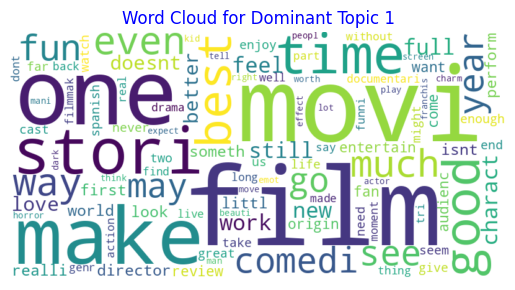

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



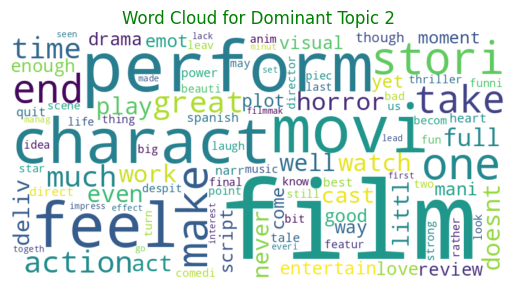

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



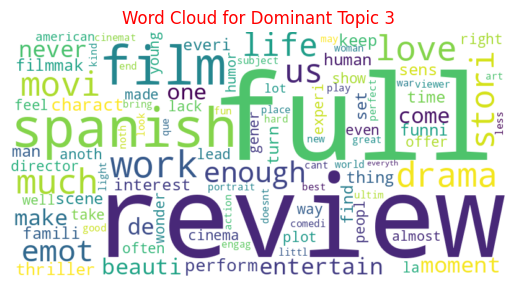

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Define the stopwords to exclude from the word cloud
stopwords = set(STOPWORDS)

# Define the colors for each dominant topic
color_map = {1: 'blue', 2: 'green', 3: 'red'}

# Create a dictionary of words and their frequencies for each dominant topic
topic_word_freq = {1: {}, 2: {}, 3: {}}

for index, row in df.iterrows():
    # Extract the preprocessed review and the dominant topic
    review = row['Preprocessed_Review']
    topic = row['Dominant_Topic']

    # Split the review into words
    words = review.split()

    # Count the frequency of each word for the current dominant topic
    for word in words:
        if word not in stopwords:
            if word in topic_word_freq[topic]:
                topic_word_freq[topic][word] += 1
            else:
                topic_word_freq[topic][word] = 1

# Create a word cloud for each dominant topic
for topic, word_freq in topic_word_freq.items():
    wc = WordCloud(background_color="white", max_words=100, width=800, height=400)
    wc.generate_from_frequencies(word_freq)

    # Set the title and color of the word cloud based on the dominant topic
    plt.title("Word Cloud for Dominant Topic {}".format(topic), color=color_map[topic])

    # Show the word cloud
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


## Similarity

Topic 0 (row 0): Topic 0 is identical to itself (1.000030, slightly higher than 1 due to numerical rounding errors). It has low similarity to Topic 1 (0.006628) and Topic 2 (0.005129), meaning that Topic 0 has distinct features compared to the other two topics.

Topic 1 (row 1): Topic 1 is identical to itself (1.000018, slightly higher than 1 due to numerical rounding errors). It has low similarity to Topic 0 (0.006628) and slightly higher similarity to Topic 2 (0.026459), meaning that Topic 1 is somewhat similar to Topic 2 but still distinct.

Topic 2 (row 2): Topic 2 is identical to itself (1.000021, slightly higher than 1 due to numerical rounding errors). It has low similarity to Topic 0 (0.005129) and slightly higher similarity to Topic 1 (0.026459), meaning that Topic 2 is somewhat similar to Topic 1 but still distinct.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Get the topic-term matrix from the LDA model
topic_term_matrix = lda_model.get_topics()

# Compute the pairwise cosine similarity between the topics
topic_similarity_matrix = cosine_similarity(topic_term_matrix)

# Create a DataFrame to display the results
topic_similarity_df = pd.DataFrame(topic_similarity_matrix)
topic_similarity_df.columns = [i+1 for i in range(topic_similarity_df.shape[1])]
topic_similarity_df.index = [i+1 for i in range(topic_similarity_df.shape[0])]
topic_similarity_df.index = [3, 2, 1]
topic_similarity_df.columns = [3, 2, 1]


display(topic_similarity_df)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,3,2,1
3,1.000030,0.006628,0.005129
2,0.006628,1.000018,0.026459
1,0.005129,0.026459,1.000021


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



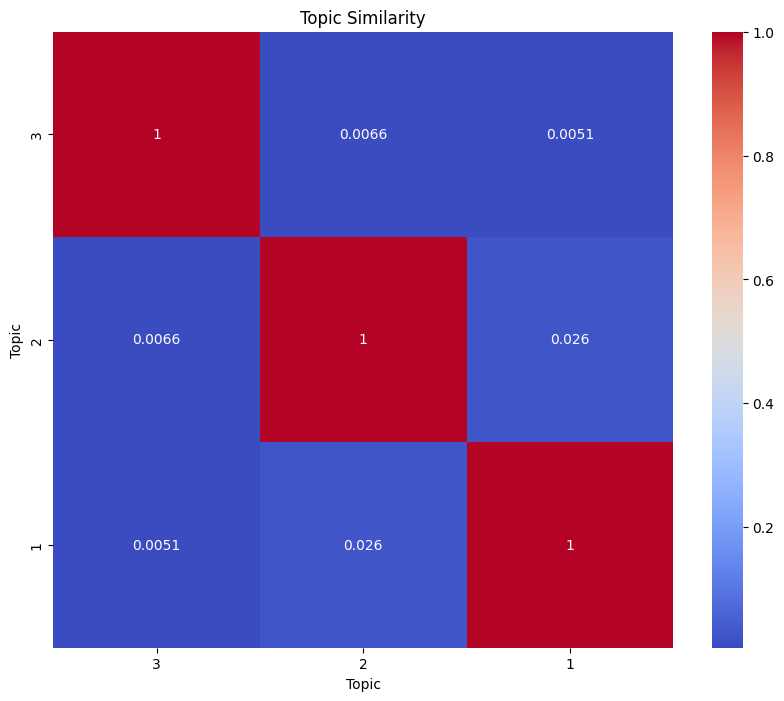

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))
sns.heatmap(topic_similarity_df, annot=True, cmap="coolwarm")
plt.title("Topic Similarity")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()


In [ ]:
topic_similarity_df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,1,2,3
1,0.005129,0.026459,1.000021
2,0.006628,1.000018,0.026459
3,1.000030,0.006628,0.005129


# prediction models

## Vectorize -- TF idf and 1gram to 3 gram

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Assuming your preprocessed reviews are in a DataFrame called df with a column named 'Preprocessed_Review'
corpus = df['Preprocessed_Review']

# Perform TF-IDF vectorization with stop words removed
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,3))
tfidf_matrix = vectorizer.fit_transform(corpus)

# Get the total number of transformed features
total_features = tfidf_matrix.shape[1]
print("Total number of transformed features:", total_features)


In [ ]:
# Get the feature names and their corresponding scores (sum of TF-IDF values across all documents)
feature_names = vectorizer.get_feature_names_out()
feature_scores = tfidf_matrix.sum(axis=0).A1

# Create a DataFrame with the feature names and their scores
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': feature_scores})

# Sort the DataFrame by importance in descending order and take the top 20 features
top_features = feature_importance.sort_values(by='importance', ascending=False).head(20)

# Plot the important features
plt.figure(figsize=(10, 5))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top 20 Important Features')
plt.show()

In [ ]:
top_features

## Chi-square Feature selction


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:
# Assuming 'new_score' is the target column in your DataFrame
target = df['new_score']

# Select the top k features
k = 1000


chi2_selector = SelectKBest(chi2, k=k)
chi2_selector.fit(tfidf_matrix, target)
selected_features = chi2_selector.get_support()

# Create a new matrix with selected features
reduced_tfidf_matrix = tfidf_matrix[:, selected_features]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
feature_names = np.array(vectorizer.get_feature_names_out())
selected_feature_names = feature_names[selected_features]
chi2_scores = chi2_selector.scores_[selected_features]
selected_feature_scores = pd.DataFrame({'feature': selected_feature_names, 'chi2_score': chi2_scores})
selected_feature_scores = selected_feature_scores.sort_values(by='chi2_score', ascending=False)


n = 30  # Adjust this value
top_n_features = selected_feature_scores.head(n)

plt.figure(figsize=(10, 6))
sns.barplot(x='chi2_score', y='feature', data=top_n_features, palette='viridis')
plt.title(f'Top {n} Features with Highest Chi-Square Scores')
plt.xlabel('Chi-Square Score')
plt.ylabel('Feature')
plt.show()


In [ ]:
top_n_features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold, train_test_split



# Find the optimal k using cross-validation and logistic regression
kf = KFold(n_splits=5, shuffle=True, random_state=42)

k_values = range(1000, 5001, 500)  # Adjust the range of k values to test
best_k = None
best_score = -np.inf

for k in k_values:
    chi2_selector = SelectKBest(chi2, k=k)
    chi2_selector.fit(tfidf_matrix, target)
    reduced_tfidf_matrix = chi2_selector.transform(tfidf_matrix)

    clf = LogisticRegression(random_state=42)
    scores = cross_val_score(clf, reduced_tfidf_matrix, target, cv=kf, scoring='f1_macro')
    mean_score = np.mean(scores)

    if mean_score > best_score:
        best_score = mean_score
        best_k = k

    print(f"k = {k}, F1-score = {mean_score:.4f}")

print(f"Best k value: {best_k}, Best F1-score: {best_score:.4f}")

## Models
Logistic

Svm

Random Forest

Xg boost

In [ ]:
# Train classifiers using the reduced feature set
chi2_selector = SelectKBest(chi2, k=best_k)
chi2_selector.fit(tfidf_matrix, target)
reduced_tfidf_matrix = chi2_selector.transform(tfidf_matrix)

from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(reduced_tfidf_matrix, target, test_size=0.3, random_state=42)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

classifiers = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('SVM', SVC(probability=True, random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
]

results = []

for name, clf in classifiers:
    clf.fit(X_train_balanced, y_train_balanced)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    results.append((name, accuracy, precision, recall, f1, fpr, tpr, roc_auc))

    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")



In [ ]:
import pandas as pd

# Create a dictionary of the metrics
metrics = {
    'Logistic Regression': {
        'Accuracy': 0.7263,
        'Precision': 0.8930,
        'Recall': 0.7172,
        'F1-score': 0.7955
    },
    'SVM': {
        'Accuracy': 0.7638,
        'Precision': 0.8921,
        'Recall': 0.7757,
        'F1-score': 0.8298
    },
    'Random Forest': {
        'Accuracy': 0.7521,
        'Precision': 0.8056,
        'Recall': 0.8779,
        'F1-score': 0.8402
    },
    'XGBoost': {
        'Accuracy': 0.7661,
        'Precision': 0.7974,
        'Recall': 0.9181,
        'F1-score': 0.8535
    }
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(metrics)

df.head()


In [ ]:
plt.figure(figsize=(8, 6))
for name, _, _, _, _, fpr, tpr, roc_auc in results:
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


## Tuning SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 100],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
}

# Initialize the SVM model
svm = SVC()

# Set up the GridSearchCV
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the SVM model with the best parameters
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = best_svm.predict(X_test)


In [ ]:
print("Best parameters found:", best_params)
print("Best accuracy score:", best_score)

# Evaluate the performance of the best model on the test set
from sklearn.metrics import accuracy_score, classification_report

test_accuracy = accuracy_score(y_test, y_pred_svm)
print("Test set accuracy:", test_accuracy)

# Print the classification report
print("Classification report:")
print(classification_report(y_test, y_pred_svm))


#  Recommendation


## Based on similarity

This part build a content-based movie recommendation system developed to suggest movies to reviewers based on their past reviews.


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 1. Filter the data based on the new_score condition
filtered_df = df[df['new_score'] == 1]

# Calculate the TF-IDF for each review
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['Tokenized_Review'].apply(lambda x: ' '.join(x)))

# Associate the TF-IDF vectors with the corresponding reviewer names
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=filtered_df['Reviewer'], columns=tfidf_vectorizer.get_feature_names_out())

# Add the dominant topic information to the TF-IDF DataFrame
num_topics = filtered_df['Dominant_Topic'].nunique()
topic_matrix = np.zeros((len(filtered_df), num_topics))
for i, topic in enumerate(filtered_df['Dominant_Topic']):
    topic_matrix[i, int(topic)] = 1

topic_df = pd.DataFrame(topic_matrix, index=filtered_df['Reviewer'], columns=[f'Topic_{i}' for i in range(num_topics)])

# Concatenate the dominant topic information with the TF-IDF matrix
combined_df = pd.concat([tfidf_df, topic_df], axis=1)

# Calculate the average combined feature vectors for all reviews by the same reviewer
avg_combined = combined_df.groupby(combined_df.index).mean()

# 3. Calculate the similarity between reviewers using cosine similarity
reviewer_similarity = cosine_similarity(avg_combined)

# Convert similarity matrix to a DataFrame
similarity_df = pd.DataFrame(reviewer_similarity, index=avg_combined.index, columns=avg_combined.index)



# 4. For a given reviewer, find the most similar reviewers (excluding themselves)
def get_similar_reviewers(reviewer_name, n=5):
    similar_reviewers = similarity_df[reviewer_name].sort_values(ascending=False).iloc[1:n+1]
    return similar_reviewers

def recommend_movies(reviewer_name, n_similar_reviewers=5, n_movies=5):
    similar_reviewers = get_similar_reviewers(reviewer_name, n_similar_reviewers)
    similar_reviewers_movies = filtered_df[filtered_df['Reviewer'].isin(similar_reviewers.index)]

    # Calculate the average dominant topic value for each movie
    movie_avg_topic = similar_reviewers_movies.groupby('Movie')['Dominant_Topic'].mean()

    # Sort the movies by the highest average dominant topic value and select the top 5
    top_movies = movie_avg_topic.sort_values(ascending=False).head(n_movies).index

    return top_movies

# Example usage
reviewer_name = 'Steve Davis'  # Replace with the desired reviewer's name
recommended_movies = recommend_movies(reviewer_name)
print(f"Top 5 recommended movies for {reviewer_name}:")
for movie in recommended_movies:
    print(f"  - {movie}")




In [ ]:
def recommend_movies(reviewer_name, n_similar_reviewers=5, n_movies=5):
    similar_reviewers = get_similar_reviewers(reviewer_name, n_similar_reviewers)
    similar_reviewers_movies = filtered_df[filtered_df['Reviewer'].isin(similar_reviewers.index)]

    # Calculate the average dominant topic value for each movie
    movie_avg_topic = similar_reviewers_movies.groupby('Movie')['Dominant_Topic'].mean()

    # Sort the movies by the highest average dominant topic value and select the top 5
    top_movies = movie_avg_topic.sort_values(ascending=False).head(n_movies).index

    return top_movies

# Example usage
reviewer_name = 'Steve Davis'  # Replace with the desired reviewer's name
recommended_movies = recommend_movies(reviewer_name)
print(f"Top 5 recommended movies for {reviewer_name}:")
for movie in recommended_movies:
    print(f"  - {movie}")